In [61]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import preproccessing as prep
from evaluation import show_scenarios_evaluation, percentile_summary
from regime_switching_brownian_motion import RegimeSwitching
from independent_lognormal_model import IndependentLogNormal
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def convert_to_transition_matrix(p00,p10):
     k =2
     transition_matrix = np.zeros((k,k))
     transition_matrix[0,0] = p00
     transition_matrix[1,0] = p10
     transition_matrix[:,1] = 1 - transition_matrix[:,0]
     return transition_matrix


In [3]:
world = pd.read_excel('msci_world_usd_30.10.23.xlsx',index_col='Date', parse_dates=True)
world = world.squeeze()
world_returns = prep.log_returns(world)
world_returns.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 645 entries, 1970-01-30 to 2023-09-29
Series name: WORLD Standard (Large+Mid Cap)
Non-Null Count  Dtype  
--------------  -----  
645 non-null    float64
dtypes: float64(1)
memory usage: 10.1 KB


In [4]:
periods = [
    ('1970-11-01', '2023-10-30'),
    ('1973-11-01', '2023-10-30'),
    ('1973-11-01', '2019-12-31'),
    ('1983-11-01', '2023-10-30'),
    ('1993-11-01', '2023-10-30'),
    ('1994-01-01', '2023-10-30'),
    ('1999-01-01', '2023-10-30'),
    ('2000-03-01', '2023-07-31'),
    ('2003-11-01', '2023-10-30'),    
    ('2013-11-01', '2023-10-30'),
]

prep.asset_stats(world_returns,periods)

,Annualised Mean,Annualised Sigma,Skew,Kurtosis,Sharp_ratio,Max drowdawn
"(1970-11-01, 2023-10-30)",0.086692,0.149740,-0.741006,2.083054,1.311509,-0.540291
"(1973-11-01, 2023-10-30)",0.083414,0.152316,-0.734475,1.982212,1.214788,-0.540291
"(1973-11-01, 2019-12-31)",0.084773,0.148525,-0.775601,2.290275,1.277495,-0.540291
"(1983-11-01, 2023-10-30)",0.087665,0.153639,-0.821811,2.135338,1.300174,-0.540291
"(1993-11-01, 2023-10-30)",0.069209,0.153336,-0.846681,1.913494,0.885784,-0.540291
"(1994-01-01, 2023-10-30)",0.069964,0.153121,-0.853065,1.959404,0.904120,-0.540291
"(1999-01-01, 2023-10-30)",0.054665,0.157324,-0.775767,1.730128,0.543091,-0.540291
"(2000-03-01, 2023-07-31)",0.053600,0.158716,-0.798951,1.770707,0.515079,-0.540291
"(2003-11-01, 2023-10-30)",0.073676,0.155547,-0.923110,2.514783,0.972673,-0.540291
"(2013-11-01, 2023-10-30)",0.076207,0.147438,-0.532838,1.085640,1.085649,-0.254242


my chosen params
mu1 = 1.35
mu2 = -0.11
sig1 = 0.07
sig2 = 0.33
p00 = 92.38
p20 = 8.74

In [5]:
data = world_returns
n_regimes = 2
params = []

for period in periods:
    model = sm.tsa.MarkovRegression(
    data[period[0]:period[1]],
    k_regimes=n_regimes,
    switching_variance=True,
    freq=None
    )
    result = model.fit()
    for k in range(n_regimes):
        result.params[f'sigma2[{k}]'] = np.sqrt(result.params[f'sigma2[{k}]'])
    
    params.append(np.round(result.params * 100,2))

params = pd.DataFrame(data=params, index=periods)
params

c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BM will be used.
  self._init_dates(dates, freq)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BM will be used.
  self._init_dates(dates, freq)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BM will be used.
  self._init_dates(dates, freq)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BM will be used.
  self._init_dates(dates, freq)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\si

,p[0->0],p[1->0],const[0],const[1],sigma2[0],sigma2[1]
"(1970-11-01, 2023-10-30)",92.89,9.55,1.36,-0.13,2.63,5.75
"(1973-11-01, 2023-10-30)",92.36,8.90,1.37,-0.11,2.60,5.75
"(1973-11-01, 2019-12-31)",93.15,8.74,1.35,-0.13,2.59,5.67
"(1983-11-01, 2023-10-30)",91.88,8.38,1.44,-0.00,2.46,5.71
"(1993-11-01, 2023-10-30)",94.20,5.34,1.35,-0.18,2.37,5.66
"(1994-01-01, 2023-10-30)",94.50,5.50,1.34,-0.20,2.40,5.70
"(1999-01-01, 2023-10-30)",94.75,4.42,1.35,-0.31,2.33,5.68
"(2000-03-01, 2023-07-31)",94.68,4.60,1.39,-0.40,2.29,5.79
"(2003-11-01, 2023-10-30)",94.66,6.41,1.30,-0.21,2.29,6.05
"(2013-11-01, 2023-10-30)",72.29,9.99,1.76,0.24,0.81,4.85


Sample paths


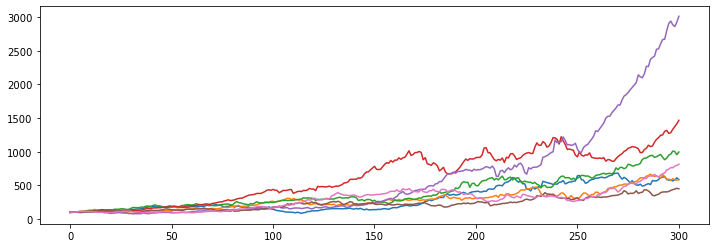

None
Fanchart


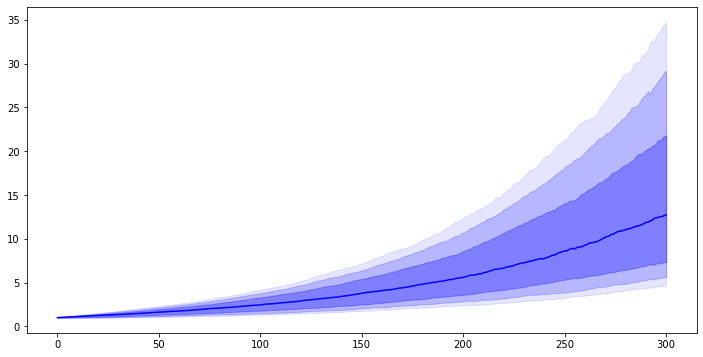

None
Percentaile summary


,12,36,60,120,240,300
10,0.965997,1.005626,1.111750,1.472834,3.076957,4.626988
15,1.000254,1.088275,1.219672,1.657681,3.688058,5.628607
25,1.050159,1.198702,1.396288,2.040874,4.891296,7.339054
50,1.145286,1.424326,1.753905,2.909685,7.754174,12.730497
75,1.241681,1.666533,2.180274,3.996592,12.838409,21.808176
85,1.287806,1.828381,2.421294,4.673530,16.304091,29.163496
90,1.320820,1.932317,2.604381,5.219080,19.291768,34.807924


Scenarios summary stats


,Annualised Mean,Annualised Sigma,Skew,Kurtosis,Sharp_ratio,Max drowdawn
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.101534,0.140551,-0.387999,1.759653,1.811873,-0.359279
std,0.031635,0.012488,0.276769,0.863262,0.879766,0.110030
min,-0.030665,0.101048,-1.594201,0.123009,-1.521359,-0.774673
25%,0.079728,0.132318,-0.566258,1.185075,1.185890,-0.425848
50%,0.101760,0.140858,-0.383351,1.649113,1.790832,-0.345622
75%,0.123291,0.149006,-0.203150,2.148479,2.394340,-0.279030
max,0.195629,0.176174,0.733819,10.810621,5.217060,-0.111041


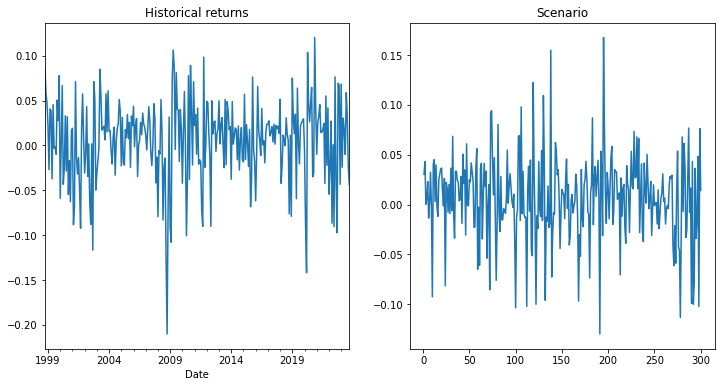

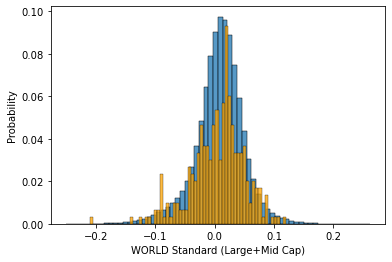

In [106]:
t_m = convert_to_transition_matrix(0.924,0.087)
initial_values=100
current_regime=0
dt=1
n_scenarios=2000
n_steps= 300
hist=world_returns

def show_RSLN_scenarios_evaluation(mu1, mu2, sigma1, sigma2, p00,p10, initial_values, current_regime, dt, n_scenarios, n_steps, hist):
      
    transition_matrix = convert_to_transition_matrix(p00/100,p10/100)

    model = RegimeSwitching(
    models=[IndependentLogNormal(mu=mu1/100,sigma=sigma1/100),
            IndependentLogNormal(mu=mu2/100,sigma=sigma2/100)],
    probs=transition_matrix
    )

    scenarios = model.scenarios(initial_values,current_regime,dt,n_steps, n_scenarios)
    scenarios = pd.DataFrame(data=scenarios, index=range(n_scenarios), columns=range(n_steps+1))

    show_scenarios_evaluation(scenarios,hist)



""" interact_manual(show_RSLN_scenarios_evaluation,         
         mu1=(0.1,5,0.01),
         mu2=(-3,3,0.01),
         sigma1=(1,7, 0.01),
         sigma2=(1,7, 0.01),
         p00 = (80,99,0.01),
         p10 = (1,20,0.01),
         initial_values=100,
         current_regime=0,
         dt=1,
         n_scenarios=2000,
         n_steps= 300,
         hist=fixed(world_returns.iloc[-300:])
         ) """

#(1973-11-01, 2023-10-30)	92.36	8.90	1.37	-0.11	2.60	5.75
show_RSLN_scenarios_evaluation(mu1=1.37, 
                               mu2=-0.11, 
                               sigma1=2.6, 
                               sigma2=5.75, 
                               p00=95.00,
                               p10=8.9,
                               initial_values=100,
                               current_regime=0,
                               dt=1,
                               n_scenarios=2000,
                               n_steps=300,
                               hist=world_returns.iloc[-300:]
                               )

In [48]:
input = world['1973-10-01':'2023-10-30'].pct_change()
input.std()*12**0.5


0.15126952721663883

In [97]:
0.063/12

0.00525

Sample paths


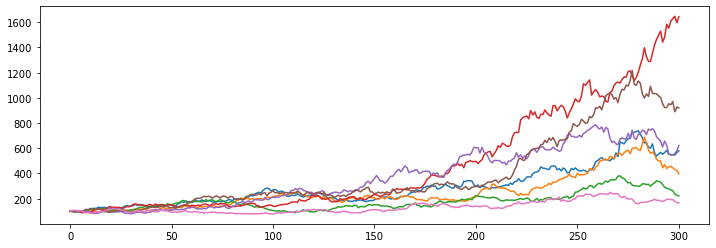

None
Fanchart


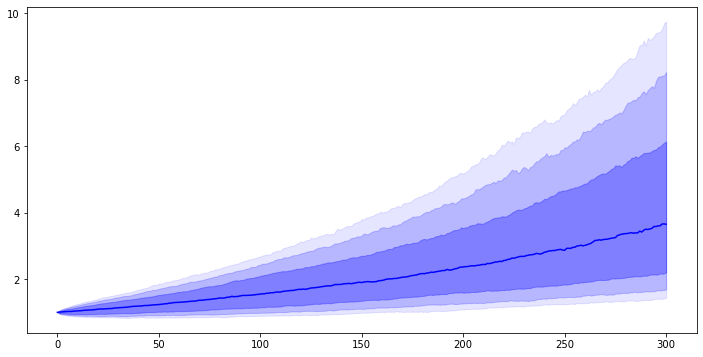

None
Percentaile summary


,12,36,60,120,240,300
10,0.868396,0.834146,0.841570,0.909850,1.239837,1.435592
15,0.900065,0.896302,0.917716,1.029460,1.415463,1.690078
25,0.950586,0.972864,1.034690,1.214655,1.787699,2.202155
50,1.050637,1.166675,1.300534,1.688027,2.808387,3.650778
75,1.169275,1.383045,1.613401,2.321916,4.420740,6.143057
85,1.238428,1.507589,1.831943,2.773230,5.701669,8.237535
90,1.284448,1.602356,1.992010,3.132385,6.808567,9.757222


Scenarios summary stats


,Annualised Mean,Annualised Sigma,Skew,Kurtosis,Sharp_ratio,Max drowdawn
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.052202,0.151295,0.004296,-0.002622,0.509047,-0.402867
std,0.030047,0.006184,0.143018,0.282171,0.690043,0.110336
min,-0.046769,0.129528,-0.439049,-0.705972,-1.817593,-0.810589
25%,0.031577,0.147036,-0.091690,-0.200642,0.037574,-0.472131
50%,0.051798,0.151277,0.000018,-0.029332,0.499777,-0.384982
75%,0.072613,0.155222,0.102912,0.158709,0.970519,-0.322662
max,0.151752,0.173385,0.515949,1.315649,2.968028,-0.153811


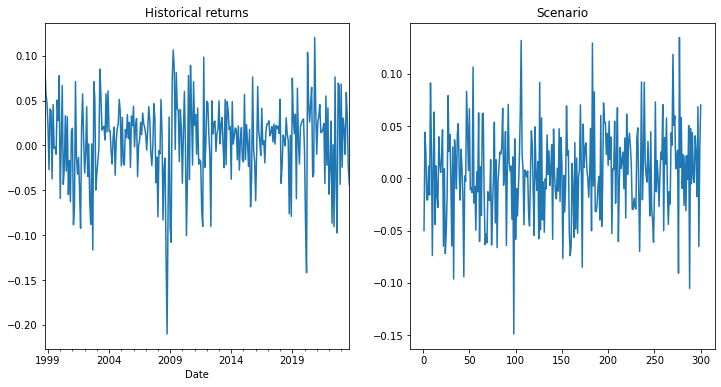

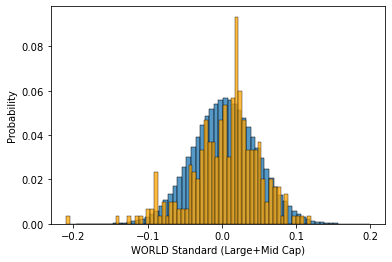

In [98]:
from pyesg import GeometricBrownianMotion
#0.083414	0.152316
scenarios = GeometricBrownianMotion(mu=0.0053,sigma=0.0437).scenarios(100,1, n_scenarios=2000, n_steps=300)
scenarios = pd.DataFrame(scenarios)
show_scenarios_evaluation(scenarios,world_returns.iloc[-300:])

In [139]:
mu1=1.37 
mu2=-0.11 
sigma1=2.6 
sigma2=5.75 
p00=92.36
p10=8.9

transition_matrix = convert_to_transition_matrix(p00/100,p10/100)

rs = RegimeSwitching(
models=[IndependentLogNormal(mu=mu1/100,sigma=sigma1/100),
        IndependentLogNormal(mu=mu2/100,sigma=sigma2/100)],
         probs=transition_matrix
    )

rs_scenarios = rs.scenarios(100,1,1,300,5000)
rs_scenarios = pd.DataFrame(rs_scenarios)

gbm_scenarios = GeometricBrownianMotion(mu=0.0079,sigma=0.0437).scenarios(100,1, n_scenarios=5000, n_steps=300)
gbm_scenarios = pd.DataFrame(gbm_scenarios)

print('gbm')
gbm_cum_returns = gbm_scenarios/100
percentiles_gbm = percentile_summary(gbm_cum_returns,data_freq=12, years=np.array([1,3,5,10,20,25]))
display(percentiles_gbm.pow(1/np.array([1,3,5,10,20,25]), axis=1)-1)

print('rs')
rs_cum_returns = rs_scenarios/100
percentiles_rs = percentile_summary(rs_cum_returns,data_freq=12, years=np.array([1,3,5,10,20,25]))
display(percentiles_rs.pow(1/np.array([1,3,5,10,20,25]), axis=1)-1)



gbm
Percentaile summary


,12,36,60,120,240,300
10,-0.103547,-0.031973,-0.005390,0.021927,0.039428,0.045128
15,-0.068280,-0.010197,0.011165,0.033563,0.048364,0.052873
25,-0.016628,0.022060,0.036313,0.052256,0.061628,0.064518
50,0.087053,0.084371,0.086294,0.086666,0.086831,0.086511
75,0.203524,0.149511,0.137570,0.123158,0.111683,0.109344
85,0.268276,0.190279,0.166483,0.141854,0.125954,0.122177
90,0.320177,0.215551,0.184269,0.155426,0.134835,0.130429


rs
Percentaile summary


,12,36,60,120,240,300
10,-0.160912,-0.058655,-0.022400,0.009495,0.032891,0.037684
15,-0.121881,-0.034715,-0.001963,0.024500,0.042720,0.046211
25,-0.063866,0.003789,0.025846,0.044464,0.057245,0.060787
50,0.058098,0.079005,0.081997,0.084366,0.084966,0.085223
75,0.183898,0.149458,0.137134,0.123578,0.112397,0.110175
85,0.255689,0.185668,0.167183,0.145169,0.126481,0.123245
90,0.308667,0.210735,0.184969,0.160522,0.135626,0.131343


In [153]:
T = 120
gbm_summary = np.exp(prep.log_returns(gbm_scenarios.T)[-T:].sum(axis=0)).describe(percentiles=[0.05,0.1,0.25,0.5,0.75,0.9,0.95])
rs_summary = np.exp(prep.log_returns(rs_scenarios.T)[-T:].sum(axis=0)).describe(percentiles=[0.05,0.1,0.25,0.5,0.75,0.9,0.95])
np.round(pd.DataFrame([gbm_summary,rs_summary], index=['gbm','rsln']),2)

,count,mean,std,min,5%,10%,25%,50%,75%,90%,95%,max
gbm,5000.0,2.58,1.29,0.38,1.04,1.24,1.69,2.32,3.18,4.24,5.03,14.16
rsln,5000.0,2.62,1.44,0.33,0.92,1.12,1.62,2.32,3.29,4.48,5.36,16.30


In [7]:
usdpln = prep.loadStooqData('usdpln','1998-12-01','d')
usdpln = usdpln.resample('M').last()
usdpln_ret = prep.log_returns(usdpln)
world_pln = (world * usdpln).dropna()
world_pln_returns = prep.log_returns(world_pln)
prep.assets_performance(world_pln_returns['2000-01-01':])

Annualised Mean     0.068650
Annualised Sigma    0.156900
Skew               -0.504753
Kurtosis            0.998444
Sharp_ratio         0.853329
Max drowdawn       -0.498474
dtype: float64

In [8]:
df = pd.DataFrame(data=[world_returns['1999-01-01':],usdpln]).T
df['WORLD Standard (Large+Mid Cap)'].fillna(method='ffill', inplace=True)
df.dropna(axis=0, inplace=True)

In [9]:
print(df['Zamkniecie'].corr(df['WORLD Standard (Large+Mid Cap)']))
print(df['Zamkniecie'].std()*np.sqrt(12))

-0.07107105760576571
1.9048306874983327


In [10]:
print('Pln original regime params')
n_regimes =2
model = sm.tsa.MarkovRegression(
    world_pln_returns['1999-01-01':],
    k_regimes=n_regimes,
    switching_variance=True,
    freq=None
    )
result = model.fit()
for k in range(n_regimes):
    result.params[f'sigma2[{k}]'] = np.sqrt(result.params[f'sigma2[{k}]']) 
result.params

Pln original regime params


c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


p[0->0]      0.934645
p[1->0]      0.089467
const[0]     0.015634
const[1]    -0.004344
sigma2[0]    0.031173
sigma2[1]    0.059894
dtype: float64

In [ ]:
# porównaj dla modelu gbm i rLN, zaanualizowana stope zwrotu (stopa skumulowana-1)**(1/t)

In [11]:
print('usd params')
n_regimes =2
model = sm.tsa.MarkovRegression(
    df['WORLD Standard (Large+Mid Cap)'],
    k_regimes=n_regimes,
    switching_variance=True,
    freq=None
    )
result = model.fit()
for k in range(n_regimes):
    result.params[f'sigma2[{k}]'] = np.sqrt(result.params[f'sigma2[{k}]']) 
result.params

usd params


c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


p[0->0]      0.948296
p[1->0]      0.040980
const[0]     0.013564
const[1]    -0.003695
sigma2[0]    0.023114
sigma2[1]    0.056310
dtype: float64

In [12]:
df['Regimes'] = result.smoothed_marginal_probabilities.idxmax(axis=1)
print('Regime 0 std, corr with world')
usdpln_reg0_std = df[df['Regimes']==0]['Zamkniecie'].std()
print(usdpln_reg0_std * np.sqrt(12))
usdpln_reg0_corr = df[df['Regimes']==0]['Zamkniecie'].corr(df[df['Regimes']==0]['WORLD Standard (Large+Mid Cap)'])
print(usdpln_reg0_corr)
usdpln_reg0_mean = df[df['Regimes']==0]['Zamkniecie'].mean()*12
print(usdpln_reg0_mean)
print('Regime 1 std, corr with world')
print(df[df['Regimes']==1]['Zamkniecie'].std()*np.sqrt(12))
print(df[df['Regimes']==1]['Zamkniecie'].corr(df[df['Regimes']==1]['WORLD Standard (Large+Mid Cap)']))
usdpln_reg1_mean = df[df['Regimes']==1]['Zamkniecie'].mean()
print(usdpln_reg1_mean)

Regime 0 std, corr with world
1.324892787471495
-0.0381986714092158
41.72649284671534
Regime 1 std, corr with world
2.2396899827798324
-0.04173634897282714
3.6709624539877304


In [13]:
print('World pln calculate regime0 std')
prep.foreign_asset_std(0.023114,usdpln_reg0_std,usdpln_reg0_corr)

World pln calculate regime0 std


0.38227907675917094

In [14]:
asset_std = df['WORLD Standard (Large+Mid Cap)'].std()
usdpln_std = df['Zamkniecie'].std()
corr = df['Zamkniecie'].corr(df['WORLD Standard (Large+Mid Cap)'])
world_pln_returns_calc = prep.foreign_asset_std(asset_std,usdpln_std,corr)

In [15]:
import gbm_gibbs as gibs
sampler = gibs.GibsSamplerGBM(world_returns['2003-01-01':'2023-07-31'],0.0064)
sampler.run()
mu = sampler.mu_dist
sig = sampler.sigma_dist
print(pd.Series(mu*12, name='mu').describe())
print(pd.Series(sig * np.sqrt(12), name='sigma').describe())


count    10001.000000
mean         0.084800
std          0.001215
min          0.000000
25%          0.084686
50%          0.084816
75%          0.084947
max          0.085475
Name: mu, dtype: float64
count    10001.000000
mean         0.218107
std          0.005744
min          0.000000
25%          0.214716
50%          0.217923
75%          0.221331
max          0.240162
Name: sigma, dtype: float64


In [16]:
sampler = gibs.GibsSamplerGBM(world_returns['1970-01-01':'2023-07-31'],0.0064)
sampler.run()
mu = sampler.mu_dist
sig = sampler.sigma_dist
print(pd.Series(mu*12, name='mu').describe())
print(pd.Series(sig * np.sqrt(12), name='sigma').describe())

count    10001.000000
mean         0.084970
std          0.001204
min          0.000000
25%          0.084939
50%          0.084986
75%          0.085034
max          0.085264
Name: mu, dtype: float64
count    10001.000000
mean         0.212233
std          0.004098
min          0.000000
25%          0.210271
50%          0.212141
75%          0.214188
max          0.226033
Name: sigma, dtype: float64


In [17]:
from typing import Any
from scipy.stats import norm

class XPdf:
    
    def __init__(self, mu, sigma) -> None:
        self.mu = mu
        self.sigma = sigma

    def __call__(self, x):
        return norm.pdf((x-self.mu)/self.sigma)
    

xpdf = XPdf(0.08,0.15)
xpdf(0.15)


0.357783429167969

In [18]:
p00 = 0.95
p10 = 0.08
mu1 = 0.1
mu2 = -0.015
sigma1 = 0.08
sigma2 = 0.19
transition_matrix = convert_to_transition_matrix(p00,p10)
xpdf1 = XPdf(mu1, sigma1)
xpdf2 = XPdf(mu2, sigma2)

def initial_state(xpdf1, xpdf2, t_m, x):
    """
    t_m : transition matrix 
    """
    pi1 = t_m[1,0]/(t_m[0,1]+t_m[1,0])
    pi2 = t_m[0,1]/(t_m[0,1]+t_m[1,0])

    f1 = (pi1*t_m[0,0] + pi2*t_m[1,0]) * xpdf1(x)
    f2 = (pi1*t_m[0,1] + pi2*t_m[1,1]) * xpdf2(x)
    fy = f1 + f2

    #probability state 1 given parameters
    pp1 = f1/fy
    pp2 = f2/fy

    return pi1, pi2, f1, f2, fy, pp1, pp2

initial_state(xpdf1,xpdf2,transition_matrix, 0.09)

x = [0.09, 0.13, -0.03]


""" 
px = prob x given pt1, pt-1 1 and 2 + pt2, pt-1 1 and 2
py = f(pt1=1,pt-1=1)+f(pt1=1,pt-1=2)+f(pt1=2,pt-1=1)+f(pt1=2,pt-1=2)
"""


' \npx = prob x given pt1, pt-1 1 and 2 + pt2, pt-1 1 and 2\npy = f(pt1=1,pt-1=1)+f(pt1=1,pt-1=2)+f(pt1=2,pt-1=1)+f(pt1=2,pt-1=2)\n'

In [19]:
def sample_states(mus,sigmas,t_m, x):

  params = np.concatenate([np.array(t_m).T[:-1].flatten(), mus,sigmas, ])
  k_regimes = len(t_m)
  T = len(x)
  states = np.zeros(T)
  regimes = range(k_regimes)

  model = sm.tsa.MarkovRegression(
    x,
    k_regimes=k_regimes,
    switching_variance=True,
    )
  probs = model.smooth(params).smoothed_marginal_probabilities

  for t in range(T):
    states[t] = np.random.choice(regimes,p=probs[t],size=1)
  return states

In [20]:
mus= [0.01, 0.05]
sigmas = [0.007, 0.055]

t_m = [[0.93, 0.07], [0.06, 0.94]]
t_m3 = [[0.92, 0.06, 0.02],
        [0.05, 0.92, 0.03],
        [0.05, 0.1, 0.985]]

x = [0.02,0.01,0.08,-0.11, 0.29, 0.03]

res = []
for i in range(1000):
  res.append(sample_states(mus, sigmas, t_m,x))

np.sum(res,0)


array([238., 271., 342., 583., 876., 717.])

In [21]:
from scipy import stats

class TransitionMatrixSampler:
  
  def __init__(self, states, u0) -> None:
    self.states = states
    self.u0 = u0

  def calculate_states(self):
    k_regimes = np.unique(self.states).max()+1
    m = np.zeros((k_regimes, k_regimes))
    for t in range(len(self.states)-1):
      m[self.states[t], self.states[t+1]] +=1

    return m
  
  def distribution_params(self):
    transition_count = self.calculate_states()
    params = np.zeros((3,3,2))
    indices = np.arange(3)
    #return np.add([[transition_count[0,0], transition_count[0,1]],[transition_count[1,1],transition_count[1,0]]], self.u0)

    for m in range(3):
      mask = indices != m
      pii = transition_count[m,m]
      pij = transition_count[m,mask].sum()
      params[m,m] = [pii,pij]
      
    return params
  
  def sample(self):
    params = self.distribution_params()
    transition_matrix = np.zeros_like(params)
    k_regimes = len(transition_matrix)
    last = [1,0]

    for k in range(k_regimes):
      transition_matrix[k,k] = stats.beta(params[k,0],params[k,1]).rvs(1)
      transition_matrix[k,last[k]] = 1 - transition_matrix[k].sum()

    return transition_matrix
  
states3 = [1,0,0,0,1,1,0,1,2,0,2,2,1]
states2 = [1,0,0,0,1,1,0,1,0,1]
u02 = [[0.98,0.02],[0.02,0.98]]
u03 = [[0.98,0.02, 0.02],[0.02,0.98, 0.02],[0.02,0.02,0.98] ]

sampler = TransitionMatrixSampler(states3, u03)
count = sampler.calculate_states()
print(count)
print(sampler.distribution_params())

#sampler.sample()


[[2. 2. 1.]
 [2. 1. 1.]
 [1. 1. 1.]]
[[[2. 3.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [1. 3.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [1. 2.]]]


[[[2,3],[2,1]],
 [[1,3],[2,1],
 [[1,2],[1,2]]]

[[[0,[1,2],[1,2]],
 [[1,[0,2]],[0,2]]
]

In [22]:
arr = np.array([[2, 2, 1,],
                [2, 1, 1,],
                [1, 1, 1,]])

indices = [0,1,2]

mask = np.array(indices) != 2
arr[0][mask]

array([2, 2])

In [23]:
import numpy as np

# Let's assume you have a square matrix 'A'
A = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

print(A)
# For lower triangular matrix, get row starting from index zero
lower_triangular = np.tril(A)
print(lower_triangular)
for i in range(lower_triangular.shape[0]):
    print("Row", i, ":", lower_triangular[i])

# For upper triangular matrix, get row starting from last index
upper_triangular = np.triu(A)
print(upper_triangular)
for i in range(upper_triangular.shape[0]-1, -1, -1):
    print("Row", i, ":", upper_triangular[i])


[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[1 0 0]
 [4 5 0]
 [7 8 9]]
Row 0 : [1 0 0]
Row 1 : [4 5 0]
Row 2 : [7 8 9]
[[1 2 3]
 [0 5 6]
 [0 0 9]]
Row 2 : [0 0 9]
Row 1 : [0 5 6]
Row 0 : [1 2 3]


In [24]:
x = np.arange(9)
x = np.reshape(x,(3,3))
print(x)
shift = 3 - 1
np.roll(x,shift,axis=1)

[[0 1 2]
 [3 4 5]
 [6 7 8]]


array([[1, 2, 0],
       [4, 5, 3],
       [7, 8, 6]])

In [25]:
np.arange(16).reshape((4,4))

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

In [26]:
np.eye(4) @ np.arange(16).reshape((4,4))


array([[ 0.,  1.,  2.,  3.],
       [ 4.,  5.,  6.,  7.],
       [ 8.,  9., 10., 11.],
       [12., 13., 14., 15.]])

In [27]:
def sample_states(mus,sigmas,t_m, x):

  params = np.concatenate([np.array(t_m).T[:-1].flatten(), mus,sigmas, ])
  k_regimes = len(t_m)
  T = len(x)
  states = np.zeros(T,dtype=np.int32)
  regimes = range(k_regimes)

  model = sm.tsa.MarkovRegression(
    x,
    k_regimes=k_regimes,
    switching_variance=True,
    )
  probs = model.smooth(params).smoothed_marginal_probabilities
  
  for t in range(T):
    states[t] = np.random.choice(regimes,p=probs[t],size=1) 
  
  return states

mus= [0.01, 0.05]
sigmas = [0.007, 0.055]

t_m = [[0.93, 0.07], [0.06, 0.94]]
t_m3 = [[0.92, 0.06, 0.02],
        [0.05, 0.92, 0.03],
        [0.05, 0.1, 0.985]]

#x = [0.02,0.01,0.08,-0.11, 0.29, 0.03]
x = world_returns.to_numpy()

res = []
for i in range(1000):
  res.append(sample_states(mus, sigmas, t_m,x))

np.sum(res,0)


array([ 60,  27,  17,  10,  10,  13,   4,   6,   4,   5,   2,   4,   5,
         3,   1,   3,   3,   3,   1,   1,   5,   6,   7,   5,   5,   4,
         7,   5,   6,   2,   5,   5,   2,   5,   8,   2,   1,   3,   3,
         6,   5,   4,   5,   5,   6,  12,  11,  11,   7,   6,   4,   3,
         7,   5,  12,  12,  15,  10,  10,  10,  13,  12,   7,   3,   2,
         7,  11,   4,   4,   7,  10,   2,   5,   4,   0,   7,   6,   4,
         4,   5,   3,   1,   3,   6,   8,   5,   3,   3,   2,   5,   5,
         3,   8,   5,   7,   6,   6,   5,   2,   4,   6,   2,   6,   5,
         2,   5,   4,   3,   5,  10,   3,   4,   5,   6,   4,   5,   4,
         4,   3,   7,   5,   5,  21,   9,   3,   3,   7,   5,   6,   8,
         4,   4,   5,   1,   7,   6,   3,   3,   4,   8,   7,   5,   5,
         4,   3,   8,   4,   6,   7,   7,   2,   5,  11,   6,   6,   4,
         4,   1,   5,   2,   5,   6,   8,   4,   1,   4,   1,   2,   7,
         6,   4,   8,   7,   5,   6,  10,   4,   3,   2,   4,   

In [28]:
from scipy.stats import beta

class TransitionMatrixSampler:

  def __init__(self, states, u0) -> None:
    self.states = states
    self.u0 = u0
    self.k_regimes = np.unique(self.states).max()+1
    self.transition_count = self.calculate_states_transitions()
    self.alfas = np.full((self.k_regimes, self.k_regimes),np.nan)
    self.betas = np.full((self.k_regimes, self.k_regimes), np.nan)

    self.calculate_distribution_params()

  def calculate_states_transitions(self):

    m = np.zeros((self.k_regimes, self.k_regimes))
    for t in range(len(self.states)-1):
      m[self.states[t], self.states[t+1]] +=1

    return m

  def calculate_distribution_params(self):
    params = np.zeros((self.k_regimes,self.k_regimes,2))
    indices = np.arange(self.k_regimes, dtype=np.int32)

    for i in indices:      
      row = np.roll(indices,-i)
      ui = np.roll(self.u0[i],-i)
      for j in indices[:-1]:        
        self.alfas[i,row[j]] = np.add(self.transition_count[i,row[j]],ui[j])
        mask = np.all([indices != i,indices != row[j]],axis=0) 
        self.betas[i,row[j]] = self.transition_count[i,mask].sum()   
             
   

  def sample(self):

    t_m = np.full((self.k_regimes,self.k_regimes),np.nan)

    for i in range(self.k_regimes):      
      alfas = np.roll(self.alfas[i],-i)
      betas = np.roll(self.betas[i],-i)
      for j in range(self.k_regimes-1):
        t_m[i,j] = np.random.beta(alfas[j],betas[j],1)
      t_m[i,-1] = 1 - np.nansum(t_m[i])           
      t_m[i] = np.roll(t_m[i],i)
        
    return t_m

states3 = [1,0,0,0,1,1,0,1,2,0,2,2,1]
states2 = [1,0,0,0,1,1,0,1,0,1]
states4 = [1,0,0,3,0,1,1,0,3,3,1,3,2,0,2,2,1,2,2,3,3,3,0,1,2,1,2,1,2,3,2,3,2,3,3,1,0,0,0,0,0,0,0]
u02 = [[0.98,0.02],[0.02,0.98]]
u03 = [[0.98,0.02, 0.02],[0.02,0.98, 0.02],[0.02,0.02,0.98]]
u04 = np.array([[0.96,0.02, 0.02, 0.02],[0.02,0.96, 0.02, 0.02],[0.02,0.02, 0.96, 0.02,], [0.02,0.02, 0.02,0.96,]])

sampler = TransitionMatrixSampler(states4, u04)

print(sampler.transition_count)
print('alfas:')
print(sampler.alfas)
print('betas')
print(sampler.betas)

sample = sampler.sample()
sample


[[7. 2. 1. 2.]
 [3. 1. 4. 1.]
 [1. 3. 2. 4.]
 [2. 2. 3. 4.]]
alfas:
[[7.96 2.02 1.02  nan]
 [ nan 1.96 4.02 1.02]
 [1.02  nan 2.96 4.02]
 [2.02 2.02  nan 4.96]]
betas
[[ 5.  3.  4. nan]
 [nan  8.  4.  7.]
 [ 7. nan  8.  4.]
 [ 5.  5. nan  7.]]


array([[ 0.477349  ,  0.49989989,  0.300721  , -0.27796989],
       [ 0.36986328,  0.12405761,  0.418933  ,  0.08714611],
       [ 0.25988755,  0.19717458,  0.20337602,  0.33956185],
       [ 0.08061917,  0.40705566, -0.02112978,  0.53345495]])

In [29]:
def rs_gibs_sampler(x, mus0, sigmas0, t_m0, u0, n_samples):

  xn = []
  if(isinstance(x,pd.DataFrame)):
    xn = x.to_numpy()
  
  t_m = np.zeros((n_samples,t_m0.shape[0],t_m0.shape[0]))

  for n in range(n_samples):
    states = sample_states(mus0,sigmas0,t_m0,xn)
    t_m[n] = TransitionMatrixSampler(states,u0).sample()

  return t_m



mus= [0.01, 0.05]
sigmas = [0.007, 0.055]

t_m = np.array([[0.93, 0.07], [0.06, 0.94]])
u0 = [[0.98, 0.02], [0.02, 0.98] ]

t_m3 = [[0.92, 0.06, 0.02],
        [0.05, 0.92, 0.03],
        [0.05, 0.1, 0.985]]

x = world_returns #[0.02,0.01,0.08,-0.11, 0.29, 0.03]


t_m = rs_gibs_sampler(x, mus, sigmas, t_m, u0,1000)


ValueError: zero-size array to reduction operation maximum which has no identity